In [1]:
import csv
import numpy as np
import scipy
import networkx as nx
import math
import sys
import os
import subprocess
import scipy.stats
import scipy.optimize
import operator
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from scipy.sparse import csr_matrix

sys.path.append("../Python_code") # go to parent dir
from canvas_vis import * 
from analytics_combined import *
from generate_proj_to_remove import *
from project_data_analysis import *
from user_embedding import *
from segmentation import *
from evaluation import *
import pickle

In [2]:
#Parameters

#Area of the canvas considered (0-1002,0-1002 is the full canvas)
min_x = 0
max_x = 1002
min_y = 0
max_y = 1002

#distance threshold in update graphs
#updates within dist_threshold positions from each other
#that co-exist at any point in time will be connected
dist_threshold = 4

#Multithreading
num_threads = 3

#Kappa parameter for the region segmentation of the
#update graph
KAPPA_updates = 1.

#Kappa parameter for the segmentation of the
#region graph
KAPPA_region = .55

#User signed embedding parameters
ndim=160
threshold=5
total_samples=300
n_negatives=5
n_iterations=10

In [3]:
#Reading ground truth data

t = time.time()

projects_to_remove = get_list_of_removed_proj(output_filename = "../data/proj_to_remove.txt")

input_file= "../data/sorted_tile_placements_proj.csv"
js_filename = "../data/atlas_complete.json"

names, descriptions = read_picture_names_and_descriptions(js_filename)

print("time = ", time.time()-t, " seconds")

time =  373.59283447265625  seconds


In [4]:
#Creating and saving update graph and associated list of updates

t = time.time()

G_ups, ups = create_graph(input_file, projects_to_remove, dist_threshold, min_x, max_x, min_y, max_y)

print("num edges = ", G_ups.n_edges)

pfile = open('graph.pkl', 'wb')
pickle.dump(G_ups, pfile)
pfile.close()

pfile = open('ups.pkl', 'wb')
pickle.dump(ups, pfile)
pfile.close()

print("time = ", time.time()-t, " seconds")

num edges =  468152954
time =  11285.80235362053  seconds


In [4]:
#Reading existing update graph and associated list of updates

pfile = open('graph.pkl', 'rb')
G_ups = pickle.load(pfile)
pfile.close()

pfile = open('ups.pkl', 'rb')
ups = pickle.load(pfile)
pfile.close()

In [5]:
def size_one_regions(ups):
    '''
        Size one regions from updates.
    '''
    regions = []

    for u in range(len(ups)):
        regions.append([u])
        
    return regions

In [6]:
regions = size_one_regions(ups)

In [ ]:
ndims = [80, 160, 240, 320]



In [83]:
def compute_user_color(regions, ups):
    '''
        Computes, for each update, a vector
        with frequencies of colors used by 
        its author.
    '''
    user_index = {}

    for r in range(len(regions)):
        for u in regions[r]:
            up = ups[u]
            user = up[1]
            
            if user not in user_index:
                user_index[user] = len(user_index)

    user_color = np.zeros((len(user_index)+1, 16))

    for r in range(len(regions)):
        for u in regions[r]:
            up = ups[u]
            user = up[1]
            color = int(up[4])

            idx_user = user_index[user]
            user_color[idx_user][color] = user_color[idx_user][color] + 1

    for i in range(user_color.shape[0]):
        if user_color[i].sum() > 0:
            user_color[i] = user_color[i] / user_color[i].sum()

    region_color = np.zeros((len(regions), 16))
    
    for r in range(len(regions)):
        for u in regions[r]:
            up = ups[u]
            user = up[1] 
            
            region_color[r] = region_color[r] + user_color[user_index[user]]
            
        region_color[r] = region_color[r] / len(regions[r])
    
    return scipy.sparse.csr_matrix(region_color)

def compute_user_avg_update_pos(regions, ups):
    '''
    '''
    user_index = {}

    for r in range(len(regions)):
        for u in regions[r]:
            up = ups[u]
            user = up[1]
            
            if user not in user_index:
                user_index[user] = len(user_index)

    user_avg = np.zeros((len(user_index)+1, 2))
    count = np.zeros(len(user_index)+1)
                                
    for r in range(len(regions)):
        for u in regions[r]:
            up = ups[u]
            user = up[1]
            x = up[2]
            y = up[3]

            idx_user = user_index[user]
            user_avg[idx_user] = user_avg[idx_user] + np.array([x,y])
            count[idx_user] = count[idx_user] + 1

    for i in range(user_avg.shape[0]):
        if count[i].sum() > 0:
            user_avg[i] = user_avg[i] / count[i]

    region_avg = np.zeros((len(regions), 2))
    
    for r in range(len(regions)):
        for u in regions[r]:
            up = ups[u]
            user = up[1] 
            
            region_avg[r] = region_avg[r] + user_avg[user_index[user]]
            
        region_avg[r] = region_avg[r] / len(regions[r])
    
    return region_avg

def compute_colors(regions, ups):
    '''
        Computes sparse matrix of color frequencies
        for each region.
    '''
    rows = []
    cols = []
    data = []
    for r in range(len(regions)):
        region = regions[r]
        colors = np.zeros(16)
        for u in region:
            up = ups[u]
            color = int(up[4])
            colors[color] = colors[color] + 1

        colors = colors / np.sum(colors)

        for c in range(len(colors)):
            if colors[c] > 0:
                rows.append(r)
                cols.append(c)
                data.append(colors[c])

    return scipy.sparse.csr_matrix((data, (rows, cols)), shape=(len(regions), 16))

def compute_user_vectors(regions, user_vec, user_index, ups):
    '''
        Compute mean of user_vec for the region
        Works for the signed embedding and color embedding
    '''
    user_vec_regions = np.zeros((len(regions), user_vec.shape[1]))

    for r in range(len(regions)):
        for u in regions[r]:
            user = ups[u][1]
            idx_user = user_index[user]

            if scipy.sparse.issparse(user_vec):
                user_vec_regions[r] = user_vec_regions[r] + user_vec[idx_user].todense()
            else:
                user_vec_regions[r] = user_vec_regions[r] + user_vec[idx_user]

            user_vec_regions[r] = user_vec_regions[r] / len(regions[r])

    return user_vec_regions


In [81]:
def sum_sizes(i, j, ups, data):
    '''
        Sum of region sizes
    '''
    return len(data['regions'][i])+len(data['regions'][j])

def diff_sizes(i, j, ups, data):
    '''
        Difference of region sizes
    '''
    return np.abs(len(data['regions'][i])-len(data['regions'][j]))

def distance_space(i,j,ups,data):
    '''
        Computes the distance between the average
        points of two regions.
    '''
    avg_xi = 0
    avg_yi = 0
    
    for ui in data['regions'][i]:
        upi = ups[ui]
        xi = upi[2]
        yi = upi[3]
        
        avg_xi = avg_xi + xi
        avg_yi = avg_yi + yi
        
    avg_xi = avg_xi / len(data['regions'][i])
    avg_yi = avg_yi / len(data['regions'][i])
    
    avg_xj = 0
    avg_yj = 0
            
    for uj in data['regions'][j]:
        upj = ups[uj]
        xj = upj[2]
        yj = upj[3]
        
        avg_xj = avg_xj + xj
        avg_yj = avg_yj + yj
        
    avg_xj = avg_xj / len(data['regions'][j])
    avg_yj = avg_yj / len(data['regions'][j])
    
    return math.sqrt(math.pow(avg_xi-avg_xj,2)+math.pow(avg_yi-avg_yj,2))

def distance_time(i,j,ups,data):
    '''
        Computes (absolute) distance between the
        average time of two regions.
    '''
    avg_ti = 0
    for ui in data['regions'][i]:
        upi = ups[ui]
        avg_ti = avg_ti + upi[0]
    
    avg_ti = avg_ti / len(data['regions'][i])
    
    avg_tj = 0
    for uj in data['regions'][j]:
        upj = ups[uj]
        avg_tj = avg_tj + upj[0]      
    
    avg_tj = avg_tj / len(data['regions'][j])
    
    return np.abs(avg_ti-avg_tj) / 3600000 #hours

def distance_user_colors(i, j, ups, data):
    '''
        Distance between avg user color embeddings for regions.
    '''
    return 1.-np.minimum(data['user_color'][i].todense(), data['user_color'][j].todense()).sum()

def distance_colors(i, j, ups, data):
    '''
        Distance between avg user color embeddings for regions.
    '''
    return 1.-np.minimum(data['color'][i].todense(), data['color'][j].todense()).sum()

def distance_durations(i, j, ups, data):
    '''
        Distance between the durations of two regions.
    '''
    return dist_duration(data['dur'][i], data['dur'][j])

def distance_sign_embedding(i, j, ups, data):
    '''
        Distance between avg user embeddings for regions.
    '''
    return np.linalg.norm(data['sign'][i]-data['sign'][j])

def distance_act_embedding(i, j, ups, data):
    '''
        Distance between avg user embeddings for regions.
    '''
    return np.linalg.norm(data['act'][i]-data['act'][j])

def distance_user_avg_pos(i, j, ups, data):
    '''
    '''
    return np.linalg.norm(data['avg_pos'][i]-data['avg_pos'][j])

In [13]:
def embed_users_act(G, ups, ndim=40, threshold=5, total_samples=100, n_negatives=5, n_iterations=10):
    '''
    '''
    G_act, user_index = compute_user_activity_graph(G, ups)

    act_embedding(G_act, user_index, "actnet", ndim, threshold, total_samples, n_negatives,  n_iterations)

    emb = read_embedding("actnet", user_index, ndim)

    return user_index, emb

In [16]:
def compute_feature_values(edge_buffer, ups, features):
    '''
    '''
    feat_values = np.zeros((len(edge_buffer), len(features)))

    for e in range(len(edge_buffer)):
        u = edge_buffer[e][0]
        v = edge_buffer[e][1]

        for f in range(len(features)):
            feat_values[e][f] = features[f]['func'](u, v, ups, features[f]['data'])

    return feat_values

def compute_feature_values_wrapper(param):
    '''
        Simple wrapper for the compute_weight function
    '''
    #Loading pickled features
    #Each thread has its own copy, which is quite inneficient
    pfile = open(param[2], 'rb')
    features = pickle.load(pfile)
    pfile.close()

    return compute_feature_values(param[0], param[1], features)

def build_feat_label_data_multithread(G, ups, features, features_file_name, n_threads, pixel=False):
    '''
    '''
    #Pickling feature data to be shared with threads
    if not os.path.exists(features_file_name):
        pfile = open(features_file_name, 'wb')
        pickle.dump(features, pfile)
        pfile.close()
        
    n_labelled = 0
    with open(G.unique_edges_file_name, 'r') as file_in:
        reader = csv.reader(file_in)

        for r in reader:
            u = int(r[0])
            v = int(r[1])
            lb = r[2]
            type_edge = int(r[3])

            #updates.append([ts, user, x, y, color, proj, pixel, pixel_color])
            
            if type_edge > 0:
                if pixel is True:
                    if int(ups[u][6]) == 1 and int(ups[v][6]) == 1:
                        n_labelled = n_labelled + 1
                else:
                    if int(ups[u][7]) == 1 and int(ups[v][7]) == 1:
                        n_labelled = n_labelled + 1

    A = np.zeros((n_labelled, len(features)))
    b = np.zeros(n_labelled)

    edge_buffer = []
    
    i = 0
    n = 0
    with open(G.unique_edges_file_name, 'r') as file_in:
        reader = csv.reader(file_in)

        for r in reader:
            u = int(r[0])
            v = int(r[1])
            lb = int(r[2])
            type_edge = int(r[3])
            
            if type_edge > 0:
                if pixel is True:
                    if int(ups[u][6]) == 1 and int(ups[v][6]) == 1:
                        edge_buffer.append((u,v))
                        
                        if lb == 1:
                            b[i] = 0.
                        else:
                            b[i] = 1.
                            
                        i = i + 1
                else:
                    if int(ups[u][7]) == 1 and int(ups[v][7]) == 1:
                        edge_buffer.append((u,v))
                        
                        if lb == 1:
                            b[i] = 0.
                        else:
                            b[i] = 1.
                            
                        i = i + 1
                    
            if len(edge_buffer) > G.buffer_size:
                edges_per_thread = int(len(edge_buffer) / n_threads)
                edge_parts = []
    
                for t in range(n_threads):
                    edge_parts.append([])

                e = 0
                for e in range(len(edge_buffer)):
                    t = e % n_threads
                    edge_parts[t].append(edge_buffer[e])

                futures = []

                #Multithreading
                with concurrent.futures.ProcessPoolExecutor(max_workers=n_threads) as executor:
                    for t in range(n_threads):
                        fut = executor.submit(compute_feature_values_wrapper, (edge_parts[t], ups, features_file_name))
                        futures.append(fut)

                #Collecting results
                for t in range(n_threads):
                    fut = futures[t]
                    res = fut.result()
                    for e in range(res.shape[0]):
                        A[n+e*n_threads+t] = res[e]
                
                n = n + len(edge_buffer)
                        
                edge_buffer = []
                
    if len(edge_buffer) > 0:
        edges_per_thread = int(len(edge_buffer) / n_threads)
        edge_parts = []
    
        for t in range(n_threads):
            edge_parts.append([])

        e = 0
        for e in range(len(edge_buffer)):
            t = e % n_threads
            edge_parts[t].append(edge_buffer[e])

        futures = []

        #Multithreading
        with concurrent.futures.ProcessPoolExecutor(max_workers=n_threads) as executor:
            for t in range(n_threads):
                fut = executor.submit(compute_feature_values_wrapper, (edge_parts[t], ups, features_file_name))
                futures.append(fut)

        #Collecting results
        for t in range(n_threads):
            fut = futures[t]
            res = fut.result()
            for e in range(res.shape[0]):
                A[n+e*n_threads+t] = res[e]
                                        
    return A, b

In [14]:
user_color = compute_user_color(regions, ups)
color = compute_region_colors(regions, ups)
durations = compute_update_durations(ups)
region_durations = compute_region_durations(regions, durations, ups)

user_index_sign, emb_sign = embed_users_sign(G_ups, ups, ndim, threshold, total_samples, n_negatives, n_iterations, True)
user_index_act, emb_act = embed_users_act(G_ups, ups, ndim, threshold, total_samples, n_negatives, n_iterations)

sign_emb = compute_user_vector_regions(regions, emb_sign, user_index_sign, ups)
act_emb = compute_user_vector_regions(regions, emb_act, user_index_act, ups)


python ../../signet/signet.py -l signet_id.txt -i signet.txt -o signet -d 160 -t 5 -s 300
balanced:
+++  0.5976787139066786  rand =  0.2938515707880298
+--  0.17136926107885272  rand =  0.22406081377688286
unbalanced:
++-  0.20882533484044638  rand =  0.4444343216282286
---  0.022126690174022322  rand =  0.03765329380685877
avg pos =  0.8117183544019968 , n =  16547688
avg neg =  1.3827003177288753 , n =  8342489
python ../../signet/signet.py -l actnet_id.txt -i actnet.txt -o actnet -d 160 -t 5 -s 300


In [84]:
user_avg_pos = compute_user_avg_update_pos(regions, ups)

In [68]:
features = [{'name': "distance_colors", 'func': distance_colors, 'data': {'color': color}}, 
    {'name': "distance_space",  'func': distance_space, 'data': {'regions': regions}}, 
    {'name': "distance_time", 'func': distance_time, 'data': {'regions': regions}},
    {'name': "distance_user_colors", 'func': distance_user_colors, 'data': {'user_color': user_color}},
    {'name': "distance_durations", 'func': distance_durations, 'data': {'dur': durations}},
    {'name': "sum_sizes", 'func': sum_sizes, 'data': {'regions': regions}},
    {'name': "diff_sizes", 'func': diff_sizes, 'data': {'regions': regions}},
    {'name': "distance _sign_embedding", 'func': distance_sign_embedding, 'data': {'sign': sign_emb}},
    {'name': "distance_act_embedding", 'func': distance_act_embedding, 'data': {'act': act_emb}}]

pfile = open('features.pkl', 'wb')
pickle.dump(features, pfile, protocol=4)
pfile.close()

print("time = ", time.time()-t, " seconds")

time =  384709.51917147636  seconds


In [ ]:
A,b = build_feat_label_data(G_ups, ups, features, 'features.pkl')

([<matplotlib.axis.XTick at 0x7f06a757fa20>,
 <a list of 2 Text xticklabel objects>)

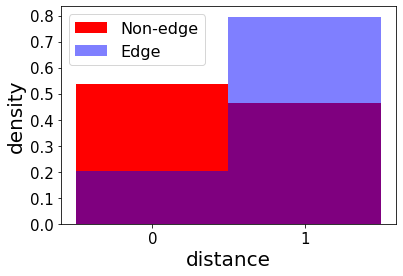

In [17]:
true_edges = A[:,0][b > 0.5]
false_edges = A[:,0][b < 0.5]

_, bins, _ = plt.hist(false_edges, bins=2, range=[0., 2.], density=True, color='r', label='Non-edge', align='left')
_ = plt.hist(true_edges, bins=bins, alpha=.5, density=True, color='b', label='Edge', align='left')
plt.xlabel("distance", fontsize=20)
plt.ylabel("density", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left', fontsize=16, ncol=1)
plt.xticks(range(2))

(0, 0.334407872842545)

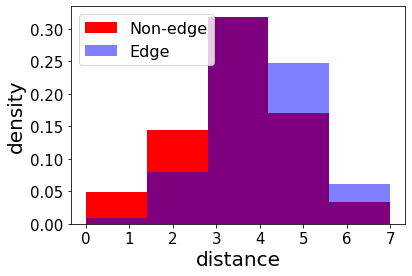

In [24]:
true_edges = A[:,1][b > 0.5]
false_edges = A[:,1][b < 0.5]

_, bins, _ = plt.hist(false_edges, bins=5, range=[0., 7.], density=True, color='r', label='Non-edge')
_ = plt.hist(true_edges, bins=bins, alpha=.5, density=True, color='b', label='Edge')
plt.xlabel("distance", fontsize=20)
plt.ylabel("density", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left', fontsize=16, ncol=1)
plt.ylim([0,None])
#plt.xticks(range(2))

(0, 0.22933579119380226)

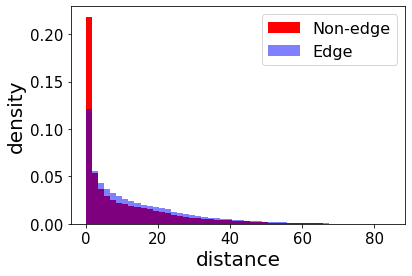

In [30]:
true_edges = A[:,2][b > 0.5]
false_edges = A[:,2][b < 0.5]

_, bins, _ = plt.hist(false_edges, bins=50, density=True, color='r', label='Non-edge')
_ = plt.hist(true_edges, bins=bins, alpha=.5, density=True, color='b', label='Edge')
plt.xlabel("distance", fontsize=20)
plt.ylabel("density", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=16, ncol=1)
plt.ylim([0,None])
#plt.xticks(range(2))

In [70]:
true_edges = A[:,3][b > 0.5]
false_edges = A[:,3][b < 0.5]

(0, 2.615978880658269)

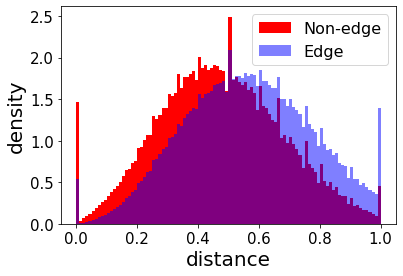

In [71]:
_, bins, _ = plt.hist(false_edges, bins=100, density=True, color='r', label='Non-edge')
_ = plt.hist(true_edges, bins=bins, alpha=.5, density=True, color='b', label='Edge')
plt.xlabel("distance", fontsize=20)
plt.ylabel("density", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=16, ncol=1)
plt.ylim([0,None])
#plt.xticks(range(2))

(0, 13.22167325035982)

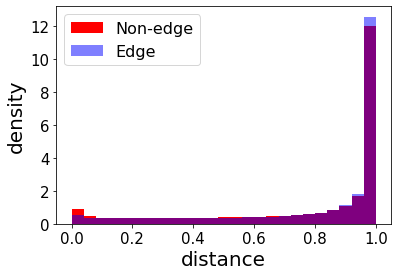

In [58]:
true_edges = A[:,4][b > 0.5]
false_edges = A[:,4][b < 0.5]

_, bins, _ = plt.hist(false_edges, bins=25, density=True, color='r', label='Non-edge')
_ = plt.hist(true_edges, bins=bins, alpha=.5, density=True, color='b', label='Edge')
plt.xlabel("distance", fontsize=20)
plt.ylabel("density", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left', fontsize=16, ncol=1)
plt.ylim([0,None])
#plt.xticks(range(2))

(0, 1.3381828118764465)

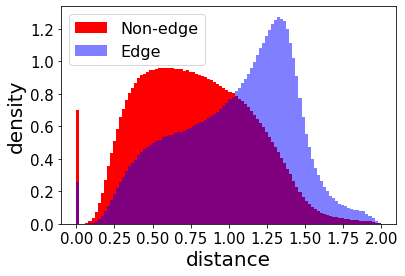

In [60]:
true_edges = A[:,7][b > 0.5]
false_edges = A[:,7][b < 0.5]

_, bins, _ = plt.hist(false_edges, bins=100, density=True, color='r', label='Non-edge')
_ = plt.hist(true_edges, bins=bins, alpha=.5, density=True, color='b', label='Edge')
plt.xlabel("distance", fontsize=20)
plt.ylabel("density", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left', fontsize=16, ncol=1)
plt.ylim([0,None])
#plt.xticks(range(2))

In [61]:
true_edges = A[:,8][b > 0.5]
false_edges = A[:,8][b < 0.5]

(0, 2.7707703969979782)

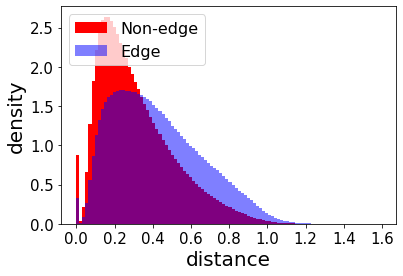

In [62]:
_, bins, _ = plt.hist(false_edges, bins=100, density=True, color='r', label='Non-edge')
_ = plt.hist(true_edges, bins=bins, alpha=.5, density=True, color='b', label='Edge')
plt.xlabel("distance", fontsize=20)
plt.ylabel("density", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left', fontsize=16, ncol=1)
plt.ylim([0,None])

In [73]:
features = [{'name': "distance_user_colors", 'func': distance_user_colors, 'data': {'user_color': user_color}}]

pfile = open('features.pkl', 'wb')
pickle.dump(features, pfile, protocol=4)
pfile.close()

print("time = ", time.time()-t, " seconds")

time =  694808.9601237774  seconds


In [74]:
A,b = build_feat_label_data(G_ups, ups, features, 'features.pkl')

In [75]:
true_edges = A[:,0][b > 0.5]
false_edges = A[:,0][b < 0.5]

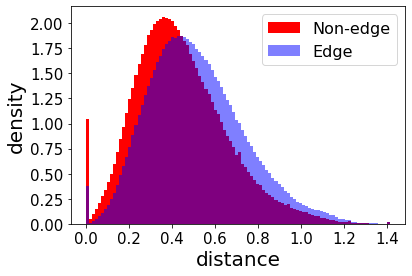

In [76]:
_, bins, _ = plt.hist(false_edges, bins=100, density=True, color='r', label='Non-edge')
_ = plt.hist(true_edges, bins=bins, alpha=.5, density=True, color='b', label='Edge')
plt.xlabel("distance", fontsize=20)
plt.ylabel("density", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=16, ncol=1)


In [85]:
features = [{'name': "distance_user_avg_pos", 'func': distance_user_avg_pos, 'data': {'avg_pos': user_avg_pos}}]

pfile = open('features.pkl', 'wb')
pickle.dump(features, pfile, protocol=4)
pfile.close()

print("time = ", time.time()-t, " seconds")

time =  816367.7802140713  seconds


In [86]:
A,b = build_feat_label_data(G_ups, ups, features, 'features.pkl')

In [87]:
true_edges = A[:,0][b > 0.5]
false_edges = A[:,0][b < 0.5]

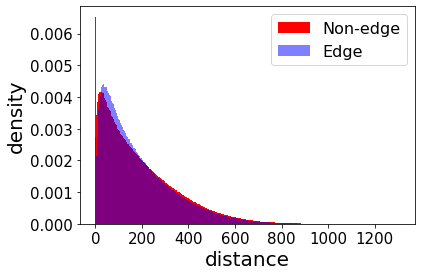

In [95]:
_, bins, _ = plt.hist(false_edges, bins=400, density=True, color='r', label='Non-edge')
_ = plt.hist(true_edges, bins=bins, alpha=.5, density=True, color='b', label='Edge')
plt.xlabel("distance", fontsize=20)
plt.ylabel("density", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper right', fontsize=16, ncol=1)
